1
Actual integral -361090873453259.7

Midpoint grid integral time 1.843095302581787
Midpoint grid integral -356510873944064.0
Midpoint grid integral abs error 4579999509195.6875
Midpoint grid integral rel error 0.012683786398130973

Monte carlo integral time 1.6306285858154297
Monte carlo integral -359636670611456.0
Monte carlo abs error 1454202841803.6875
Monte carlo rel error 0.004027248952310955

Prob that monte carlo is better 1.0


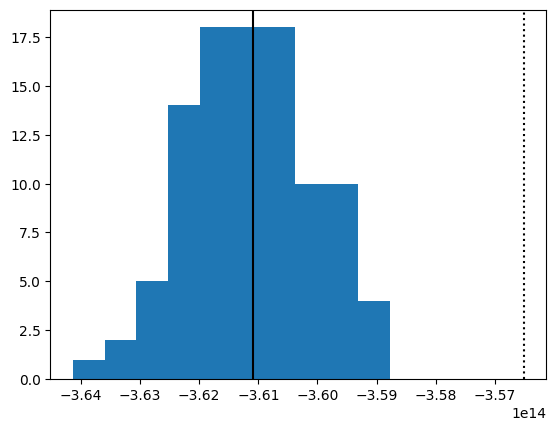

2
Actual integral -270254925662626.66

Midpoint grid integral time 1.978623867034912
Midpoint grid integral -266839607214080.0
Midpoint grid integral abs error 3415318448546.6562
Midpoint grid integral rel error 0.012637395748376393

Monte carlo integral time 1.6655981540679932
Monte carlo integral -270151362543616.0
Monte carlo abs error 103563119010.65625
Monte carlo rel error 0.00038320529683865784

Prob that monte carlo is better 1.0


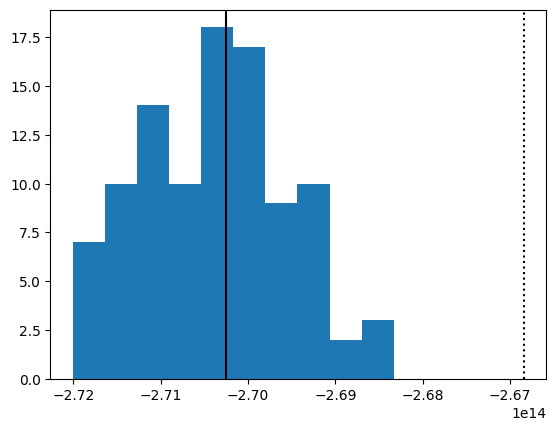

3
Actual integral -953228738629623.6

Midpoint grid integral time 1.9669296741485596
Midpoint grid integral -941241546047488.0
Midpoint grid integral abs error 11987192582135.625
Midpoint grid integral rel error 0.01257535793493658

Monte carlo integral time 1.564180612564087
Monte carlo integral -951703817945088.0
Monte carlo abs error 1524920684535.625
Monte carlo rel error 0.001599742666936243

Prob that monte carlo is better 1.0


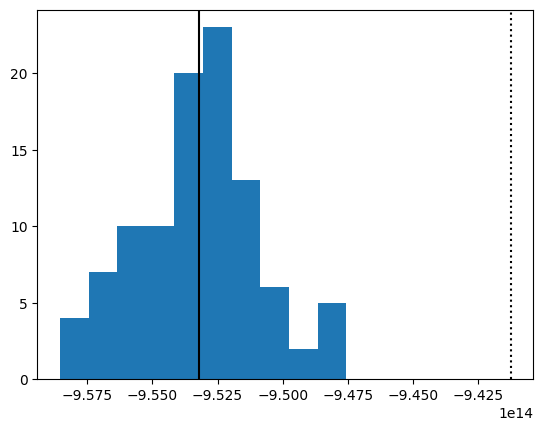

4
Actual integral -396080393825402.5

Midpoint grid integral time 1.936706781387329
Midpoint grid integral -391212196429824.0
Midpoint grid integral abs error 4868197395578.5
Midpoint grid integral rel error 0.01229093252650235

Monte carlo integral time 1.5766358375549316
Monte carlo integral -396215128686592.0
Monte carlo abs error 134734861189.5
Monte carlo rel error 0.0003401704888449816

Prob that monte carlo is better 1.0


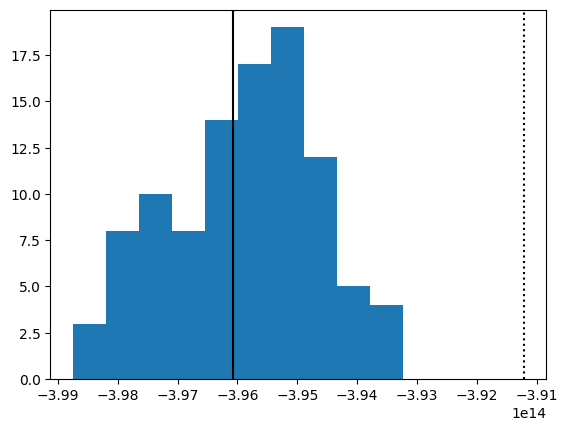

5
Actual integral -654714527637743.6

Midpoint grid integral time 1.935420036315918
Midpoint grid integral -646378887839744.0
Midpoint grid integral abs error 8335639797999.625
Midpoint grid integral rel error 0.01273171656672291

Monte carlo integral time 1.7976956367492676
Monte carlo integral -655475427246080.0
Monte carlo abs error 760899608336.375
Monte carlo rel error 0.001162185313165044

Prob that monte carlo is better 1.0


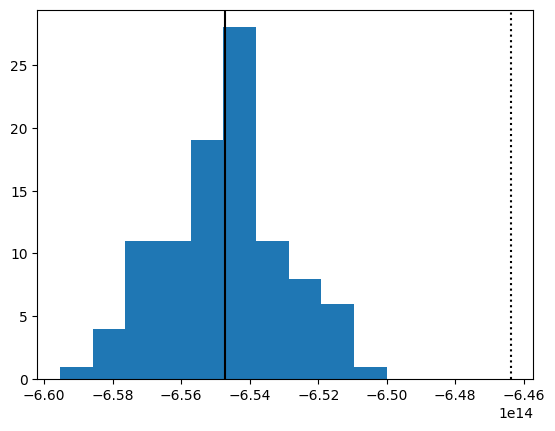

In [1]:
# Grid midpoint vs Monte carlo

import time
import matplotlib.pyplot as plt
from monte_carlo import single_variable_polynomial, polynomial_grid_midpoint_integral, polynomial_monte_carlo_integral, polynomial_integral
import random

NUMBER_OF_VARIABLES = 5
MAX_DEGREE = 2
MAX_COEFFICIENT = 10
REGION = [(-10, 10)] * NUMBER_OF_VARIABLES
GRID_N = 20
NUMBER_OF_MONTE_CARLO_INTEGRALS = 100

variables = [single_variable_polynomial(i) for i in range(NUMBER_OF_VARIABLES)]
for i in range(5):
    print(i + 1)
    polynomial = 0
    degrees = [0] * NUMBER_OF_VARIABLES
    terms_left = True
    while terms_left:
        term = (2 * random.random() - 1) * MAX_COEFFICIENT
        for i in range(NUMBER_OF_VARIABLES):
            term *= variables[i] ** degrees[i]
        polynomial += term

        terms_left = False
        for i in range(NUMBER_OF_VARIABLES-1, -1, -1):
            if degrees[i] < MAX_DEGREE:
                degrees[i] += 1
                terms_left = True
                break
            else:
                degrees[i] = 0

    monte_carlo_n = GRID_N ** len(REGION)

    actual_integral = polynomial_integral(polynomial, REGION)
    print('Actual integral', actual_integral)
    print()

    start = time.time()
    grid_midpoint_estimate = polynomial_grid_midpoint_integral(polynomial, REGION, GRID_N)
    print('Midpoint grid integral time', time.time() - start)
    print('Midpoint grid integral', grid_midpoint_estimate)
    print('Midpoint grid integral abs error', abs(grid_midpoint_estimate - actual_integral))
    print('Midpoint grid integral rel error', abs((grid_midpoint_estimate - actual_integral) / actual_integral))
    print()

    start = time.time()
    monte_carlo_estimate = polynomial_monte_carlo_integral(polynomial, REGION, monte_carlo_n)
    print('Monte carlo integral time', time.time() - start)
    print('Monte carlo integral', monte_carlo_estimate)
    print('Monte carlo abs error', abs(monte_carlo_estimate - actual_integral))
    print('Monte carlo rel error', abs((monte_carlo_estimate - actual_integral) / actual_integral))
    print()

    monte_better_count = 0
    monte_carlo_integrals = []
    for c in range(NUMBER_OF_MONTE_CARLO_INTEGRALS):
        monte_carlo_estimate = polynomial_monte_carlo_integral(polynomial, REGION, monte_carlo_n)
        monte_carlo_integrals.append(monte_carlo_estimate)
        if abs(monte_carlo_estimate - actual_integral) < abs(grid_midpoint_estimate - actual_integral):
            monte_better_count += 1
    print('Prob that monte carlo is better', monte_better_count / NUMBER_OF_MONTE_CARLO_INTEGRALS)

    plt.hist(monte_carlo_integrals)
    plt.axvline(x = actual_integral, color = "black")
    plt.axvline(x = grid_midpoint_estimate, color = "black", linestyle=":")
    plt.show()